# Problem Statement :    

 - The objective of this project is to develop a predictive model for forecasting stock prices using live data from yfinance. The model will be based on time series forecasting techniques, aiming to accurately predict the future price movements of a given stock.


Method - LSTM

In [78]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [79]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'GAIL.NS'

In [80]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [81]:
type(data)

pandas.core.frame.DataFrame

In [82]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-16,118.933334,119.833336,116.766663,118.599998,94.274292,8057787
2018-07-17,119.333336,122.116669,119.000000,119.566666,95.042686,10419621
2018-07-18,120.183334,121.849998,118.433334,119.683334,95.135422,10709484
2018-07-19,120.133331,121.349998,118.583336,119.266663,94.804199,5064312
2018-07-20,119.599998,120.933334,119.216667,119.933334,95.334145,5851905


In [83]:
len(data)

1234

In [84]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-10,111.000000,111.349998,108.300003,108.949997,108.949997,8710335
2023-07-11,108.949997,109.599998,107.650002,109.300003,109.300003,10380385
2023-07-12,109.000000,111.150002,108.949997,110.599998,110.599998,9851130
2023-07-13,110.599998,111.199997,107.849998,108.099998,108.099998,8440163
2023-07-14,108.199997,110.599998,107.500000,110.000000,110.000000,10678733


In [85]:
opn = data[['Open']]

<Axes: xlabel='Date'>

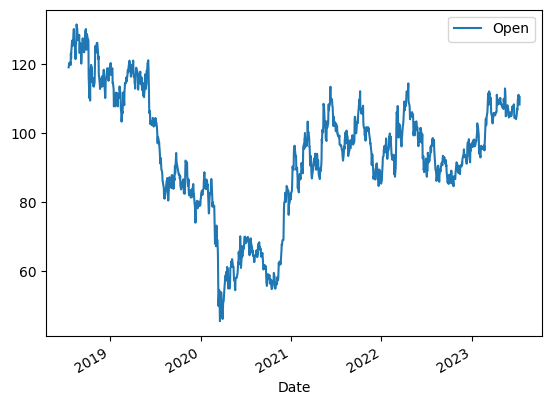

In [86]:
opn.plot()

In [87]:
import matplotlib.pyplot as plt

In [88]:
ds = opn.values

In [89]:
ds

array([[118.93333435],
       [119.33333588],
       [120.18333435],
       ...,
       [109.        ],
       [110.59999847],
       [108.19999695]])

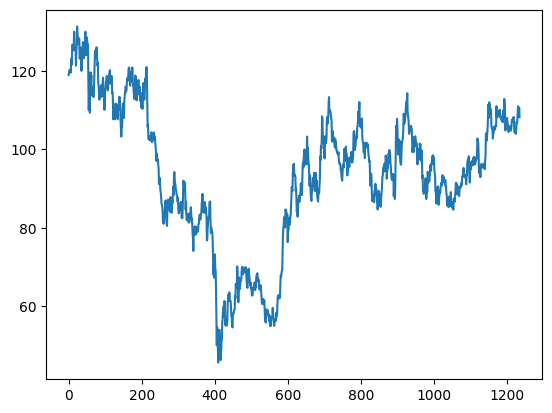

In [90]:
plt.plot(ds)

In [91]:
import numpy as np

In [92]:
from sklearn.preprocessing import MinMaxScaler

In [93]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [94]:
len(ds_scaled), len(ds)

(1234, 1234)

In [95]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [96]:
train_size,test_size

(863, 371)

In [97]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [98]:
len(ds_train),len(ds_test)

(863, 371)

In [99]:
#creating dataset in time series for LSTM model
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [100]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [101]:
X_train.shape,y_train.shape

((762, 100), (762,))

In [102]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [103]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [104]:
X_train.shape,X_test.shape

((762, 100, 1), (270, 100, 1))

In [105]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [106]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [107]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 11s 329ms/step - loss: 0.1138 - val_loss: 0.0029
Epoch 2/100
12/12 [==============================] - 3s 220ms/step - loss: 0.0140 - val_loss: 0.0027
Epoch 3/100
12/12 [==============================] - 3s 224ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 4/100
12/12 [==============================] - 4s 332ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 5/100
12/12 [==============================] - 3s 221ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 6/100
12/12 [==============================] - 3s 219ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 7/100
12/12 [==============================] - 3s 222ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 8/100
12/12 [==============================] - 3s 278ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 9/100
12/12 [==============================] - 3s 262ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 10/100
12/12 [==============================] - 3s 222ms/step - loss: 0.0038 - val_l

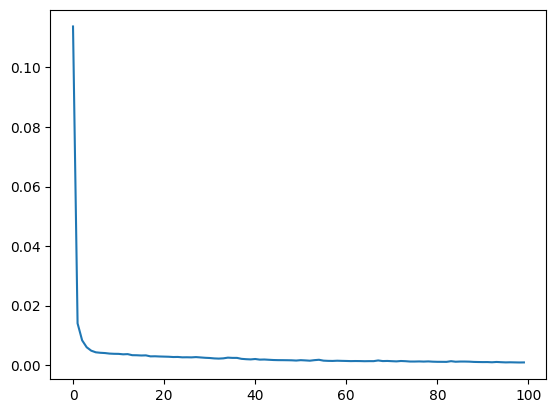

In [108]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [109]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 48ms/step


In [110]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [111]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


import math
from math import sqrt


mae_ = mae(y_test,test_predict)
mse_ = mse(y_test, test_predict)
rmse = sqrt(mse_)
print("Mean Absolute Error : ", mae_)
print("Mean Squared Error : ",mse_)
print('RMSE : ',rmse)

Mean Absolute Error :  95.59861907783946
Mean Squared Error :  9193.753690552598
RMSE :  95.884063798697


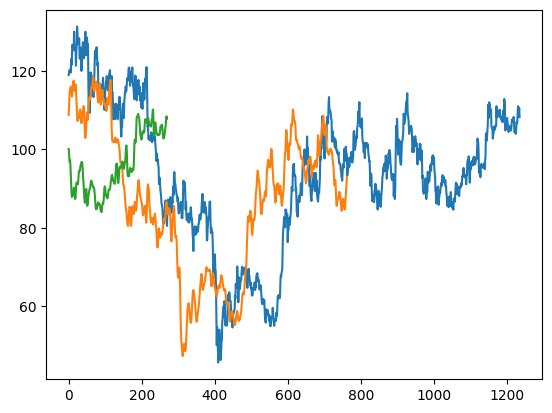

In [112]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [113]:
type(train_predict)

numpy.ndarray

In [114]:
test = np.vstack((train_predict,test_predict))

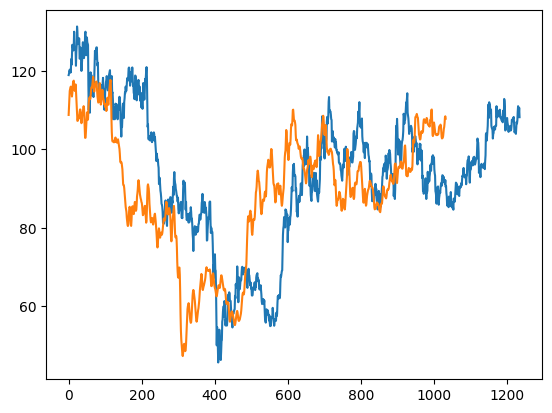

In [115]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [116]:
len(ds_test)

371

In [117]:
#Getting the last 100 days records
fut_inp = ds_test[270:]

In [118]:
fut_inp = fut_inp.reshape(1,-1)

In [119]:
tmp_inp = list(fut_inp)

In [120]:


fut_inp.shape

(1, 101)

In [121]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [122]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[[0.7204349040985107], [0.7103391885757446], [0.698104739189148], [0.6862934231758118], [0.675667405128479], [0.6660182476043701], [0.6570174694061279], [0.6485127210617065], [0.6404692530632019], [0.6328571438789368], [0.6256054043769836], [0.6186165809631348], [0.6117919087409973], [0.6050498485565186], [0.5983286499977112], [0.5915853977203369], [0.5847927331924438], [0.5779366493225098], [0.5710148811340332], [0.5640343427658081], [0.5570077300071716], [0.5499523282051086], [0.5428856015205383], [0.5358259677886963], [0.5287890434265137], [0.5217880010604858], [0.5148330330848694], [0.5079306364059448], [0.5010843873023987], [0.4942954480648041]]


In [123]:
len(ds_scaled)

1234

In [131]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,103)
plot_pred=np.arange(101,131)

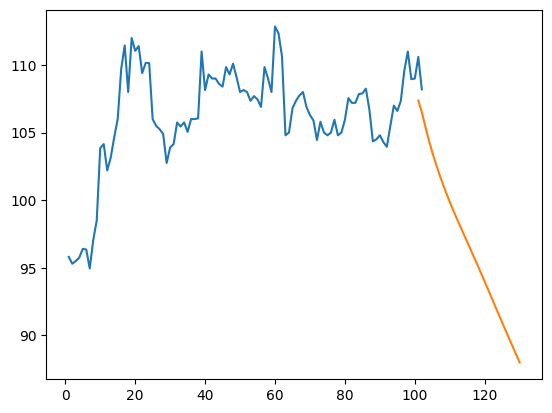

In [132]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[1132:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [133]:
ds_new = ds_scaled.tolist()

In [134]:
len(ds_new)

1234

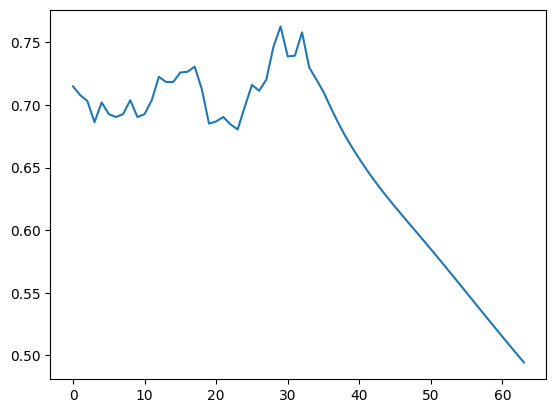

In [135]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [136]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

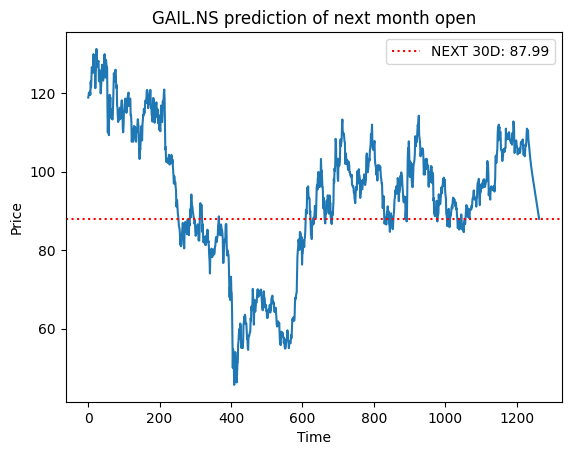

In [137]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

